# Information Retrieval

## Overview

This lab provides hands-on practice building a complete **Search Engine** from scratch using **TF-IDF (Term Frequency-Inverse Document Frequency)**, one of the most common techniques in Information Retrieval. You'll work with real datasets, implement TF-IDF vectorization, measure document similarity using cosine similarity, and build a functional search engine that can retrieve and rank documents based on user queries. This lab demonstrates the practical application of IR concepts in building production-ready search systems.

> A 2015 survey showed that 83% of text-based recommender systems in digital libraries used TF-IDF.

## Outline

1. **Setup and Imports** - Installing dependencies and importing libraries
2. **Dataset Loading** - Loading the 20 Newsgroups dataset from scikit-learn
3. **Text Preprocessing** - Preparing documents for vectorization
4. **TF-IDF Vectorization** - Converting documents and queries into numerical vectors
5. **Building the Search Engine**:
   - **Retrieval**: Finding the most similar documents to a query using cosine similarity
   - **Ranking**: Ordering documents by relevance score
   - **Classification**: Classifying queries into one of the 20 categories
6. **Testing the Search Engine** - Querying and evaluating results
7. **Understanding Results** - Interpreting search results and similarity scores

## Learning Objectives

By the end of this lab, you will be able to:

- Recognize the term-document matrix produced by the TF-IDF algorithm
- Understand how similarity is measured between text vectors (cosine similarity)
- **Work with real datasets**.
- **Implement a TF-IDF-based search engine** using:
  - Scikit-learn's `TfidfVectorizer`
  - Cosine similarity for document ranking
  - Sparse matrices for efficient storage

## Glossary of Terms

**Information Retrieval (IR)**: The task of finding information (usually documents) that satisfies an information need from within large collections.

**Corpus**: A collection of documents. In IR, this is the entire set of documents we search through.

**Query**: A user's information need expressed in natural language (e.g., "What is machine learning?").

**Document**: A unit of information in the corpus (e.g., a web page, article, or text passage).

**TF-IDF (Term Frequency-Inverse Document Frequency)**: A numerical statistic that reflects how important a word is to a document in a collection. As you learned in the vectorization lesson:
- **TF (Term Frequency)**: How often a term appears in a document
- **IDF (Inverse Document Frequency)**: How rare or common a term is across the entire corpus
- **TF-IDF**: TF × IDF, giving higher weight to terms that are frequent in a document but rare in the corpus

**Vector Space Model**: A model where documents and queries are represented as vectors in a high-dimensional space. Similarity is measured using the angle between vectors (cosine similarity).

**Cosine Similarity**: A measure of similarity between two vectors. It measures the cosine of the angle between them, ranging from -1 to 1 (or 0 to 1 for non-negative vectors like TF-IDF).

**Sparse Matrix**: A matrix where most elements are zero. TF-IDF vectors are typically sparse because most words don't appear in most documents.

**Retrieval**: The process of finding and ranking documents in response to a query.

**Ranking**: Ordering retrieved documents by their relevance score (highest to lowest).

## References

- [20 Newsgroups Dataset](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset)
- [Scikit-learn TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- [Scikit-learn cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)

## The Complete Pipeline

1. **Dataset Loading**: Load the 20 Newsgroups dataset from scikit-learn
2. **Text Preprocessing**: Prepare documents for vectorization (as learned in previous lessons)
3. **TF-IDF Vectorization**: Convert documents and queries into numerical vectors
4. Model:
   1. **Retrieval**: Find the most similar documents to a query using **cosine similarity**
   2. **Classification**: Classify a query into one of the 20 categories

### Import Libraries

We group imports by category following Python best practices. All libraries used here are part of the standard scikit-learn ecosystem:


In [1]:
# %pip install joblib==1.5.3 numpy==1.26.4 pandas==2.3.3 scikit-learn==1.8.0 --quiet

In [1]:
# Standard library imports
import json
from collections import defaultdict

# Third-party imports
import numpy as np
import pandas as pd
# Machine Learning
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

print("Libraries imported successfully!")

Libraries imported successfully!


## Loading the 20 Newsgroups Dataset

We'll use scikit-learn's **20 Newsgroups dataset**, a collection of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. This is a classic dataset for text classification and information retrieval experiments.

**About the Dataset:**
- **20 categories** of newsgroups (e.g., comp.graphics, rec.sport.baseball, sci.med)
- Each document is a newsgroup post with subject and body text
- Documents are organized by topic, which we'll use to create relevance judgments

We'll load the 20 Newsgroups dataset using scikit-learn's `fetch_20newsgroups` function. This dataset contains newsgroup posts organized into 20 categories.


In [2]:
from sklearn.datasets import fetch_20newsgroups

In [4]:
fetch_20newsgroups?

Signature:
fetch_20newsgroups(
    *,
    data_home=None,
    subset='train',
    categories=None,
    shuffle=True,
    random_state=42,
    remove=(),
    download_if_missing=True,
    return_X_y=False,
    n_retries=3,
    delay=1.0,
)
Docstring:
Load the filenames and data from the 20 newsgroups dataset (classification).

Download it if necessary.

=================   ==========
Classes                     20
Samples total            18846
Dimensionality               1
Features                  text
=================   ==========

Read more in the :ref:`User Guide <20newsgroups_dataset>`.

Parameters
----------
data_home : str or path-like, default=None
    Specify a download and cache folder for the datasets. If None,
    all scikit-learn data is stored in '~/scikit_learn_data' subfolders.

subset : {'train', 'test', 'all'}, default='train'
    Select the dataset to load: 'train' for the training set, 'test'
    for the test set, 'all' for both, with shuffled ordering.

categorie

In [5]:
# Load the 20 Newsgroups dataset
# We'll use the training set as our document collection
# remove=('headers', 'footers', 'quotes') removes metadata to focus on content
print("Loading 20 Newsgroups dataset...")
newsgroups = fetch_20newsgroups(
    subset='train',
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42,
)

Loading 20 Newsgroups dataset...


### Exercise 1: Explore the Dataset

**Task:**

- The distribution of documents across categories
- The content of sample documents
- Notice that documents are organized by topic (category)

In [6]:
df = pd.DataFrame({
    'text': newsgroups.data,
    'category': newsgroups.target,
    'category_name': [newsgroups.target_names[newsgroups.target[i]] for i in range(len(newsgroups.target))]
})
df.head()

,text,category,category_name
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


<Axes: xlabel='category'>

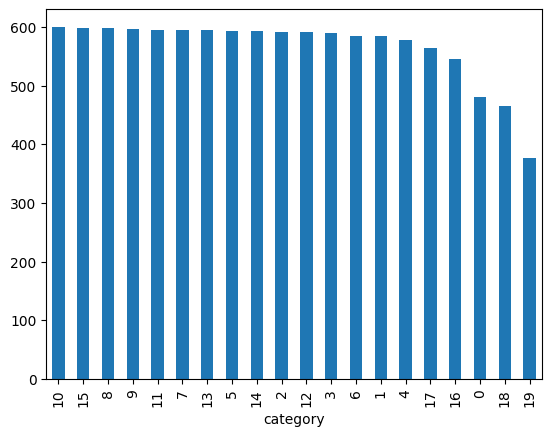

In [7]:
df['category'].value_counts().plot.bar()

### Drop columns and keep `text` only

In [8]:
df = df[['text']]
df

,text
0,I was wondering if anyone out there could enli...
1,A fair number of brave souls who upgraded thei...
2,"well folks, my mac plus finally gave up the gh..."
3,\nDo you have Weitek's address/phone number? ...
4,"From article <C5owCB.n3p@world.std.com>, by to..."
...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
11310,"I have a (very old) Mac 512k and a Mac Plus, b..."
11311,I just installed a DX2-66 CPU in a clone mothe...
11312,\nWouldn't this require a hyper-sphere. In 3-...


## Building the Search Engine

Now we'll build a TF-IDF-based search engine. The process involves:

1. **Creating TF-IDF vectors** for all documents
2. **Implementing a retrieval function**

### How TF-IDF enables retrieval

- TF-IDF weights words by their importance: rare words that appear frequently in a document get high scores
- When a user searches for "machine learning", documents with high TF-IDF scores for those terms are likely relevant
- The query is also converted to a TF-IDF vector, then compared to all document vectors

**Cosine Similarity for Document Matching**

To find relevant documents, we need to measure **similarity** between the query vector and document vectors. 

**Cosine Similarity** measures the angle between two vectors:
- It ranges from -1 to 1 (or 0 to 1 for non-negative vectors like TF-IDF)
- **1.0** = vectors point in the same direction (very similar)
- **0.0** = vectors are perpendicular (no similarity)
- **-1.0** = vectors point in opposite directions (very dissimilar)

**Why cosine similarity?**
- It measures similarity in **direction**, not magnitude
- A long document and a short document about the same topic will have similar directions (high cosine similarity)
- It's robust to document length differences
- Works well with sparse TF-IDF vectors

**The retrieval process:**
1. Convert query to TF-IDF vector (using the same vocabulary as documents)
2. Compute cosine similarity between query vector and all document vectors
3. Rank documents by similarity score (highest first)
4. Return top-k most similar documents

### Task 1: Creating TF-IDF vectors for all documents

In [9]:
# Step 2: Create TF-IDF vectors for all documents
# Initialize the vectorizer
# We use default settings, but you can customize:
# - max_features: limit vocabulary size
# - stop_words: remove common words ('english')
# - ngram_range: use unigrams and bigrams
vectorizer = TfidfVectorizer(
    lowercase=True,      # Convert to lowercase
    stop_words='english', # Remove English stop words
    max_features=5000,   # Limit vocabulary to top 5000 terms
    ngram_range=(1, 2)   # Use both unigrams and bigrams
)

In [10]:
# Fit on all documents and transform them
# This learns the vocabulary and IDF from the corpus
document_vectors = vectorizer.fit_transform(df['text'])
document_vectors

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 504091 stored elements and shape (11314, 5000)>

In [11]:
print(f"Document vectors shape: {document_vectors.shape}")
print(f"  - {document_vectors.shape[0]} documents")
print(f"  - {document_vectors.shape[1]} features (terms in vocabulary)")
print("\nThis is a sparse matrix. Let's check sparsity:")
print(f"  - Non-zero elements: {document_vectors.nnz:,}")
print(f"  - Total elements: {document_vectors.shape[0] * document_vectors.shape[1]:,}")
print(f"  - Sparsity: {(1 - document_vectors.nnz / (document_vectors.shape[0] * document_vectors.shape[1])) * 100:.2f}%")

Document vectors shape: (11314, 5000)
  - 11314 documents
  - 5000 features (terms in vocabulary)

This is a sparse matrix. Let's check sparsity:
  - Non-zero elements: 504,091
  - Total elements: 56,570,000
  - Sparsity: 99.11%


> Notice how the sparse matrix efficiently stores only non-zero values. This is why TF-IDF scales well to large document collections.

- Document vectors shape: (~11,000, 5000) - thousands of documents, 5000 features
- High sparsity (typically 95-99%) - most values are zero

Notice how there is a lot of junk in the text, when we print the vocabulary from `200:400`, this may or may not be useful, depending on your use case.

In [12]:
# Show some vocabulary terms
vocab = vectorizer.get_feature_names_out()
print(vocab[200:400])

['42' '43' '44' '45' '46' '47' '48' '486' '49' '4e' '4k' '4l' '4t' '4th'
 '4u' '50' '500' '5000' '51' '52' '53' '54' '55' '56' '57' '58' '59' '5g'
 '5g9p' '5g9v' '5k' '5s' '5u' '60' '600' '6000' '61' '617' '62' '63' '64'
 '65' '650' '66' '67' '68' '69' '6e' '6ei' '6ei 6ei' '6g' '6um' '6um 6um'
 '70' '700' '703' '71' '72' '73' '74' '75' '750' '75u' '75u 75u' '76' '77'
 '78' '79' '7ex' '7ey' '7ey 7ey' '7ez' '7klj' '7kn' '7t' '7th' '7u' '80'
 '80 bit' '800' '81' '82' '83' '84' '85' '86' '87' '88' '89' '8n' '8v'
 '90' '900' '91' '91 92' '92' '93' '94' '95' '96' '97' '98' '99' '9d' '9f'
 '9f8' '9f9' '9l' '9l3' '9p' '9s' '9v' '9v g9v' '__' '___' '____' '_____'
 '_q' '_the' 'a4' 'a7' 'a86' 'a86 a86' 'a86 lg' 'a86r' 'ab' 'abc'
 'abiding' 'ability' 'able' 'abortion' 'abs' 'absolute' 'absolutely'
 'abuse' 'ac' 'ac uk' 'academic' 'accelerator' 'accept' 'acceptable'
 'accepted' 'access' 'accident' 'accidents' 'accomplished' 'according'
 'account' 'accounts' 'accurate' 'achieve' 'acid' 'acquired' '

### Task 2: Implementing a retrieval function

- Converts a query to a TF-IDF vector
- Computes cosine similarity with all document vectors
- Returns the top-k most similar documents

In [13]:
# Step 3: Implement the retrieval function
def retrieve_documents(query_text, top_k=10):
    # Transform query to TF-IDF vector using the same vectorizer
    query_vector = vectorizer.transform([query_text])
    
    # Compute cosine similarity between query and all documents
    # cosine_similarity returns a matrix of shape (1, num_documents)
    similarities = cosine_similarity(query_vector, document_vectors).flatten()
    
    # Get indices of top-k documents (sorted by similarity, descending)
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    # Return a dataframe with the top-k results
    df_results = df.iloc[top_indices].copy()
    df_results['similarity'] = similarities[top_indices]
    return df_results

In [14]:
search_results = retrieve_documents(query_text='computer', top_k=3)
print(search_results['text'][:1])

9137    \nWhat about the common joystick found in all ...
Name: text, dtype: object


> **Note:** how the top three results are all related to the query.

## **Student Exercise**: build a search engine on the `CVs` dataset

In [2]:
# STUDENT EXERCISE
import json
from pathlib import Path
# Load CVs from JSON files in all topic folders
cv_dir = Path('../datasets/CVs/')
# Use glob pattern to find all JSON files in Topic_* subdirectories, excluding English versions
cv_files = sorted([f for f in cv_dir.glob('Topic_*/*.json') if not f.name.endswith('_en.json')])
cv_files

[PosixPath('../datasets/CVs/Topic_1/07.json'),
 PosixPath('../datasets/CVs/Topic_1/10.json'),
 PosixPath('../datasets/CVs/Topic_1/11.json'),
 PosixPath('../datasets/CVs/Topic_1/15.json'),
 PosixPath('../datasets/CVs/Topic_1/17.json'),
 PosixPath('../datasets/CVs/Topic_1/20.json'),
 PosixPath('../datasets/CVs/Topic_1/21.json'),
 PosixPath('../datasets/CVs/Topic_1/22.json'),
 PosixPath('../datasets/CVs/Topic_1/26.json'),
 PosixPath('../datasets/CVs/Topic_1/29.json'),
 PosixPath('../datasets/CVs/Topic_1/30.json'),
 PosixPath('../datasets/CVs/Topic_1/33.json'),
 PosixPath('../datasets/CVs/Topic_1/34.json'),
 PosixPath('../datasets/CVs/Topic_1/39.json'),
 PosixPath('../datasets/CVs/Topic_1/40.json'),
 PosixPath('../datasets/CVs/Topic_2/08.json'),
 PosixPath('../datasets/CVs/Topic_2/09.json'),
 PosixPath('../datasets/CVs/Topic_2/12.json'),
 PosixPath('../datasets/CVs/Topic_2/16.json'),
 PosixPath('../datasets/CVs/Topic_2/18.json'),
 PosixPath('../datasets/CVs/Topic_2/19.json'),
 PosixPath('.

In [3]:
 # extract them so each key is a column and each row is a json file
import re
cv_arr = []
for file in cv_files:
    with open(file, 'r') as f:
        data = json.load(f)
        data['Skills'] = '---'.join(data['Skills']).replace('---', ' ')
        data['Projects'] = '---'.join(data['Projects']).replace('---', ' ')
        data['Experience'] = '---'.join(data['Experience']).replace('---', ' ')
        data['Education'] = '---'.join(data['Education']).replace('---', ' ')
        data['Topic'] = file.parent.name.split('_')[-1]
        cv_arr.append(data)
cv_df = pd.DataFrame(cv_arr)
cv_df


,Heading,Skills,Projects,Experience,Education,Topic
0,"Fatima Al-Zahrani, AI Engineer","* **Programming Languages:** Python, PyTorch, ...",AI-Powered Content Generation Platform | Lead ...,Generative AI Specialist Innovatech Solutions ...,Master of Artificial Intelligence KAUST | Thuw...,1
1,"Ali Bin Nasser, AI Engineer",* **Research Areas:** Natural Language Process...,Cross-lingual Transfer Learning for Low-Resour...,Research Scientist Mohamed bin Zayed Universit...,PhD in Computer Science Stanford University | ...,1
2,"Nasser Al-Khaldi, AI Engineer","* **Programming Languages:** Python, Java, Sca...",Automated Quality Control System | Computer Vi...,AI Engineer Saudi Aramco | Dhahran [07/2022] –...,Master of Science in Artificial Intelligence K...,1
3,"Sultan Al-Fahim, AI Engineer","* **CI/CD & Automation:** Jenkins, GitLab CI, ...",CI/CD Pipeline for ML Models | MLOps Engineer ...,MLOps Engineer Emirates | Dubai [11/2021] – [P...,Bachelor of Science in Computer Science Americ...,1
4,"Dana Al-Jaber, AI Engineer",* **Generative Models:** Diffusion Models (Sta...,Fine-tuning LLMs for Domain-Specific Chatbots ...,Generative AI Specialist Majid Al Futtaim | Du...,"Master of Science in Computer Science, AI Spec...",1
5,"Abdullah Al-Ghamdi, AI Engineer","* **Research Areas:** Arabic NLP, Speech Recog...",End-to-End Arabic Speech Recognition | PhD Res...,Research Scientist King Abdulaziz City for Sci...,PhD in Electrical and Computer Engineering Joh...,1
6,"Yasmin Al-Jassim, AI Engineer","* **Programming Languages:** Python, C++, R. *...",Arabic Chatbot for Customer Service | NLP Engi...,"AI Engineer Batelco | Manama, Bahrain [09/2022...",Bachelor of Science in Computer Science Univer...,1
7,"Ibrahim Al-Saeed, AI Engineer","* **Programming:** Python, SQL. * **Deep Learn...",Object Detection for Retail Analytics | Comput...,"AI Engineer Zain | Kuwait City, Kuwait [07/202...",Master of Science in Computer Science Kuwait U...,1
8,"Hamad Al-Ghanim, Data Scientist","* **Python:** Pandas, Scikit-learn, PyTorch. *...",Multi-Label Text Classification | NLP Data Sci...,Data Scientist Saudi Electricity Company | Dam...,Master of Science in Electrical Engineering Ki...,1
9,"Faisal Al-Qahtani, AI Engineer","* **Infrastructure as Code:** Terraform, Ansib...",Automated Model Retraining Pipeline | MLOps En...,MLOps Engineer Qatar Investment Authority (QIA...,Bachelor of Engineering in Computer Engineerin...,1


In [6]:
def remove_structure(text):
    return re.sub(r'\[.*?\]', '', text)



def normalize_text(text):
    # remove all non-word characters and convert to lowercase and number and remove extra spaces using regex
    return re.sub(r'[^\w\s]', '', text).lower()

def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_data_range(text):
    # remove dates ranfe between brackets
    return re.sub(r'\[.*?\]', '', text)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)


def call_preprocessing_functions(df):
    df['Skills'] = df['Skills'].apply(remove_structure).apply(normalize_text).apply(remove_extra_spaces).apply(remove_data_range).apply(remove_numbers)
    df['Projects'] = df['Projects'].apply(remove_structure).apply(normalize_text).apply(remove_extra_spaces).apply(remove_data_range).apply(remove_numbers)
    df['Experience'] = df['Experience'].apply(remove_structure).apply(normalize_text).apply(remove_extra_spaces).apply(remove_data_range).apply(remove_numbers) 
    df['Education'] = df['Education'].apply(remove_structure).apply(normalize_text).apply(remove_extra_spaces).apply(remove_data_range).apply(remove_numbers)
    return df

# call functions in order 

cv_df=call_preprocessing_functions(cv_df)
cv_df['major']=cv_df['Heading'].str.split(',').str[-1].str.strip()
cv_df['text']=cv_df['Skills']+cv_df['Projects']+cv_df['Experience']+cv_df['Education']
# show more text by adjusting pandas display option
pd.set_option('display.max_colwidth', None)
cv_df

,Heading,Skills,Projects,Experience,Education,Topic,major,text
0,"Fatima Al-Zahrani, AI Engineer",programming languages python pytorch jax generative models gans vaes diffusion models transformers gpt llama tools platforms langchain vector databases pinecone milvus midjourney dalle cloud mlops google cloud vertex ai docker gradio streamlit,aipowered content generation platform lead generative ai developer developed a system using llms to automatically generate marketing copy and social media posts finetuned a gpt model on brandspecific data improving content relevance by image synthesis for product design creative ai researcher built a custom stylegan model to generate novel furniture designs from textual descriptions the generated images accelerated the prototyping phase by,generative ai specialist innovatech solutions jeddah designing and implementing rag retrievalaugmented generation pipelines for enterprise search improving query responses by integrating knowledge graphs with llms leading to a reduction in noanswer results building custom agents for automated workflows using langchain machine learning intern creative labs riyadh assisted in training a diffusion model for highresolution image inpainting contributed to a research paper on prompt engineering techniques,master of artificial intelligence kaust thuwal thesis controllable texttoimage generation using latent diffusion models bachelor of computer engineering effat university jeddah,1,AI Engineer,programming languages python pytorch jax generative models gans vaes diffusion models transformers gpt llama tools platforms langchain vector databases pinecone milvus midjourney dalle cloud mlops google cloud vertex ai docker gradio streamlitaipowered content generation platform lead generative ai developer developed a system using llms to automatically generate marketing copy and social media posts finetuned a gpt model on brandspecific data improving content relevance by image synthesis for product design creative ai researcher built a custom stylegan model to generate novel furniture designs from textual descriptions the generated images accelerated the prototyping phase bygenerative ai specialist innovatech solutions jeddah designing and implementing rag retrievalaugmented generation pipelines for enterprise search improving query responses by integrating knowledge graphs with llms leading to a reduction in noanswer results building custom agents for automated workflows using langchain machine learning intern creative labs riyadh assisted in training a diffusion model for highresolution image inpainting contributed to a research paper on prompt engineering techniquesmaster of artificial intelligence kaust thuwal thesis controllable texttoimage generation using latent diffusion models bachelor of computer engineering effat university jeddah
1,"Ali Bin Nasser, AI Engineer",research areas natural language processing deep learning representation learning programming frameworks python pytorch tensorflow hugging face transformers mathematical foundations advanced linear algebra probability theory optimization publication venues neurips icml acl emnlp,crosslingual transfer learning for lowresource languages phd researcher investigated methods for adapting large pretrained language models to languages with limited data proposed a novel adapterbased finetuning technique that outperformed previous methods by on a benchmark of lowresource languages efficient transformers research intern contributed to the development of a new sparse attention mechanism to reduce the computational cost of transformer models coauthored a paper accepted at the neurips conference,research scientist mohamed bin zayed university of ai mbzuai abu dhabi conducting fundamental research in the area of largescale language modeling mentoring phd students and collaborating with faculty on research projects,phd in computer science stanford university stanford ca advisor prof christopher manning master of scien

In [7]:
vectorizer = TfidfVectorizer(
    lowercase=True,      # Convert to lowercase
    stop_words='english', # Remove English stop words
    max_features=5000,   # Limit vocabulary to top 5000 terms
    ngram_range=(1, 2)   # Use both unigrams and bigrams
)
cv_df['text']
document_vectors = vectorizer.fit_transform(cv_df['text'])
document_vectors


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7226 stored elements and shape (34, 4783)>

In [8]:
print(f"Document vectors shape: {document_vectors.shape}")
print(f"  - {document_vectors.shape[0]} documents")
print(f"  - {document_vectors.shape[1]} features (terms in vocabulary)")
print("\nThis is a sparse matrix. Let's check sparsity:")
print(f"  - Non-zero elements: {document_vectors.nnz:,}")
print(f"  - Total elements: {document_vectors.shape[0] * document_vectors.shape[1]:,}")
print(f"  - Sparsity: {(1 - document_vectors.nnz / (document_vectors.shape[0] * document_vectors.shape[1])) * 100:.2f}%")

Document vectors shape: (34, 4783)
  - 34 documents
  - 4783 features (terms in vocabulary)

This is a sparse matrix. Let's check sparsity:
  - Non-zero elements: 7,226
  - Total elements: 162,622
  - Sparsity: 95.56%


In [9]:
# Show some vocabulary terms
vocab = vectorizer.get_feature_names_out()
print(vocab[200:400])

['analyst performed' 'analyst pl' 'analyst played' 'analyst red'
 'analyst riyadh' 'analyst saudia' 'analyst sidra' 'analysts'
 'analysts championing' 'analysts empower' 'analysts scientists'
 'analytics' 'analytics analytics' 'analytics business'
 'analytics computer' 'analytics created' 'analytics data'
 'analytics databricks' 'analytics designed' 'analytics engineer'
 'analytics engineering' 'analytics google' 'analytics hamad'
 'analytics junior' 'analytics looker' 'analytics model'
 'analytics platform' 'analytics reporting' 'analytics sales'
 'analytics salesforce' 'analytics software' 'analytics team'
 'analytics workflowanalytics' 'analyticsautomated'
 'analyticsautomated quality' 'analyticssenior' 'analyticssenior data'
 'analyze' 'analyze data' 'analyzed' 'analyzed clinical'
 'analyzed customer' 'analyzed performance' 'analyzing' 'analyzing data'
 'analyzing market' 'animation' 'animation prince' 'anonymized'
 'anonymized data' 'ansible' 'ansible orchestration' 'answer'
 'ans

In [12]:
# Step 3: Implement the retrieval function
def retrieve_documents(query_text, top_k=10):
    # Transform query to TF-IDF vector using the same vectorizer
    query_vector = vectorizer.transform([query_text])
    
    # Compute cosine similarity between query and all documents
    # cosine_similarity returns a matrix of shape (1, num_documents)
    similarities = cosine_similarity(query_vector, document_vectors).flatten()
    
    # Get indices of top-k documents (sorted by similarity, descending)
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    # Return a dataframe with the top-k results
    df_results = cv_df.iloc[top_indices].copy()
    df_results['similarity'] = similarities[top_indices]
    return df_results

---

In [20]:
search_results = retrieve_documents(query_text='databricks', top_k=3)
# retrun the row of the best results
best_result_index = search_results.index
print(search_results['text'][:1])
cv_df.iloc[best_result_index]

23    data architecture data mesh lakehouse architecture big data platforms databricks snowflake streaming spark structured streaming kafka cloud azure aws governance unity catalog collibraenterprise data mesh implementation principal data architect leading the initiative to implement a decentralized data mesh architecture empowering domains to own and serve their own data products unified data analytics platform cloud solutions architect architected a unified analytics platform on databricks integrating data from various sources enabled both bi and machine learning workloads on a single platformbig data architect qatarenergy doha qatar setting the technical direction for the companys data and ai platforms designing scalable and futureproof data architectures guiding teams on best practices for data modeling and data engineering senior data consultant accenture dubai uae advised clients in the energy sector on their data strategy and architecture designed and delivered several largesca

,Heading,Skills,Projects,Experience,Education,Topic,major,text
23,"Jassim Al-Mulla, Data Scientist",data architecture data mesh lakehouse architecture big data platforms databricks snowflake streaming spark structured streaming kafka cloud azure aws governance unity catalog collibra,enterprise data mesh implementation principal data architect leading the initiative to implement a decentralized data mesh architecture empowering domains to own and serve their own data products unified data analytics platform cloud solutions architect architected a unified analytics platform on databricks integrating data from various sources enabled both bi and machine learning workloads on a single platform,big data architect qatarenergy doha qatar setting the technical direction for the companys data and ai platforms designing scalable and futureproof data architectures guiding teams on best practices for data modeling and data engineering senior data consultant accenture dubai uae advised clients in the energy sector on their data strategy and architecture designed and delivered several largescale data projects,master of information systems management carnegie mellon university pittsburgh pa bachelor of science in computer engineering qatar university doha qatar,2,Data Scientist,data architecture data mesh lakehouse architecture big data platforms databricks snowflake streaming spark structured streaming kafka cloud azure aws governance unity catalog collibraenterprise data mesh implementation principal data architect leading the initiative to implement a decentralized data mesh architecture empowering domains to own and serve their own data products unified data analytics platform cloud solutions architect architected a unified analytics platform on databricks integrating data from various sources enabled both bi and machine learning workloads on a single platformbig data architect qatarenergy doha qatar setting the technical direction for the companys data and ai platforms designing scalable and futureproof data architectures guiding teams on best practices for data modeling and data engineering senior data consultant accenture dubai uae advised clients in the energy sector on their data strategy and architecture designed and delivered several largescale data projectsmaster of information systems management carnegie mellon university pittsburgh pa bachelor of science in computer engineering qatar university doha qatar
22,"Khalid Al-Ameri, Data Analyst",big data spark hadoop hive streaming kafka flink databases postgresql cassandra cloud azure data lake storage databricks data factory languages scala python sql,clickstream data processing streaming data engineer built a realtime pipeline with kafka and flink to process website clickstream data populated a dashboard for realtime user behavior analysis data warehouse modernization data architect contributed to the migration of an onpremise data warehouse to azure synapse analytics designed and implemented data models in the new cloud data warehouse,data engineer elm riyadh saudi arabia building data pipelines and dataintensive applications for government clients working with large and complex datasets related to public services ensuring data security and compliance with national data regulations database administrator saudi telecom company stc riyadh saudi arabia managed and maintained largescale oracle databases performed database tuning and optimization,bachelor of science in information systems king saud university riyadh saudi arabia certifications azure data engineer associate dp,2,Data Analyst,big data spark hadoop hive streaming kafka flink databases postgresql cassandra cloud azure data lake storage databricks data factory languages scala python sqlclickstream data processing streaming data engineer built a realtime pipeline with kafka and flink to process website clickstream data populated a dashboard for realtime user behavior analysis data warehouse modernization data architect cont

## Summary

### Key Takeaways

- **TF-IDF** is a simple but effective method for information retrieval
- **Sparse matrices** make TF-IDF scalable to large document collections

### Next Steps

- Explore other scikit-learn datasets (e.g., `fetch_20newsgroups` with different subsets)
- Try advanced techniques like BM25 (can be implemented with sklearn)